(5, 105, 25, 25, 36)
(25, 25, 36)


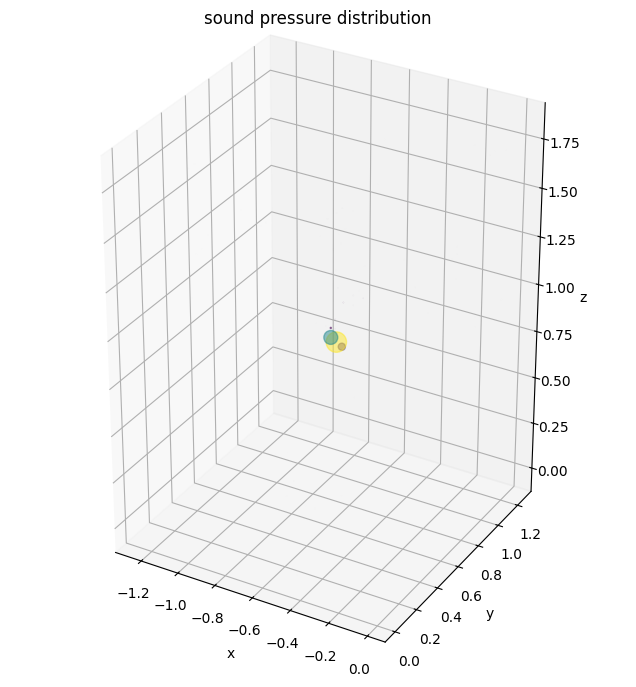

In [13]:
import numpy as np
import acoular as ac
import pyfar as pf
import matplotlib.pyplot as plt

resFileName = "out/testing/result_2025-01-28_15-59-01_400437"
dotsize = 5
resolution = 0.05

# read Data
result = np.load(resFileName + ".npy")

# start, stop, framerate, frames, frequency_bands, bandwith, resolution, name = pf.io.read(resFileName+".far")
# result_Lp = ac.L_p(result)[4,85]        # convert results in sound pressure Level
# map = result_Lp

map = result[0,42]

print(result.shape)
print(map.shape)

a = map.shape[0]

fig = plt.figure(figsize = [10,8])
ax = fig.add_subplot(projection='3d')
x_m, y_m, z_m = np.meshgrid(np.linspace(0,map.shape[0]*resolution,map.shape[0]),
                            np.linspace(0,map.shape[1]*resolution,map.shape[1]), 
                            np.linspace(0,map.shape[2]*resolution,map.shape[2]))
ax.scatter(-x_m, y_m, z_m, c = map, s = map*10**dotsize)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('sound pressure distribution')
ax.set_aspect('equal')
plt.show()